# Подготовительный этап

### Подгрузка библиотек

In [0]:
!apt install libspatialindex-dev
!pip install osmnx

In [0]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy

import csv
import json # пока писать будет в json, но если что переделаем

from heapq import heappush, heappop
from networkx.drawing.nx_pydot import graphviz_layout
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette
from scipy.cluster.hierarchy import fcluster

### Выгрузим граф Уфы с помощью библиотеки osmnx

In [0]:
place = {'city' : 'Ufa',
         'country' : 'Russia'}
G = ox.graph_from_place(place, network_type='drive', simplify=False)

Нарисуем и сохраним граф

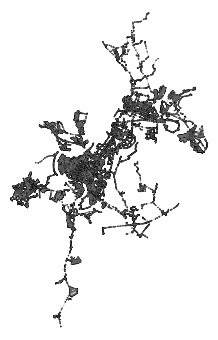

(<Figure size 468.322x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8ccaa71240>)

In [0]:
ox.plot_graph(G, dpi=500, node_color='#000000', node_size=2, edge_color='#999999', edge_linewidth=0.2, save = True, show = True, close = True, file_format='png', filename='roads_graph_Ufa')

In [0]:
# создадим список всех точек графа
nodes_list = list(G.nodes()) 

In [0]:
# пишем узлы в csv
nodes_df = pd.DataFrame(nodes_list)
nodes_df.to_csv('nodes.csv', index=False)

### Создание матрицы и листа смежности

In [0]:
# нахождение расстояний между смежными узлами 
a = G.adj
dictionary = {}
i = 0
for key, value in a.items():
    if i == 10:
        break
    for key_a, value_a in value.items():

        if key not in dictionary:
            dictionary[key] = [{key_a:value_a[0]['length']}]
        else:
            dictionary[key].append({key_a:value_a[0]['length']})                  

In [0]:
# пишем список смежности в csv
adj_list = nx.generate_adjlist(G, delimiter=' ')
with open('adjacency_list.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=' ')
    for line in adj_list:
        writer.writerow(line)

In [0]:
# матрица смежностти в пандас
G_pd = nx.to_pandas_adjacency(G)

# можно записать в эксель и это даже работает!!
G_pd.to_csv('matrix_adjacency_pandas.csv')

In [0]:
# переводив в нампаевский ndarray
# !запускать только один раз!
G_pd = G_pd.values

In [0]:
# пишем полученный ndarray в csv
with open('matrix_adjacency.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for line in G_pd:
        writer.writerow(line)

### Выбираем M больниц и N домов

In [0]:
# вытаскиваем все больницы и дома
buildings = ox.footprints.footprints_from_place(place, footprint_type='building', retain_invalid=False, which_result=1)

hospitals = []
apartments = []
build = buildings['building'].to_dict()

for key,value in build.items():
    if value == 'hospital':
        hospitals.append(key)
    elif value == 'apartments':
        apartments.append(key)


In [0]:
# для каждой больницы и дома находим соответсвующие им (ближайшие) ноды на графе
a = buildings.to_dict()
hospitals_dict = {}
apartments_dict = {}

for i in hospitals:   
    bounds = a['geometry'][i].bounds
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    hospitals_dict[i] = nearest_node

for i in apartments:
    bounds = a['geometry'][i].bounds    
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    apartments_dict[i] = nearest_node

In [0]:
# оставим только уникальные значения G
temp = hospitals_dict.copy()
hospitals_dict = {}

for key, value in temp.items():
  if value not in hospitals_dict.values():
    hospitals_dict[key] = value

temp = apartments_dict.copy()
apartments_dict = {}

for key, value in temp.items():
  if (value not in apartments_dict.values()) and (value not in hospitals_dict.values()):
    apartments_dict[key] = value

In [0]:
M = 10
N = 100

hospitals_dict = dict(random.sample(list(hospitals_dict.items()), M))
apartments_dict = dict(random.sample(list(apartments_dict.items()), N))

In [0]:
# делаем листы из выбранных значений
hospital_values = list(hospitals_dict.values())
apartments_values = list(apartments_dict.values())

In [0]:
# создаем общий лист, чтобы сделать и дома, и больницы одновременно
new_nodes = apartments_values + hospital_values
new_nodes = np.array(new_nodes)

### Дейкстра, использующая кучу

In [0]:
def dijkstra_heap (G, source):
    
    G_succ = G._succ 

    push = heappush
    pop = heappop
    weight = lambda d: min(attr.get(weight, 1) for attr in d.values()) 

    seen = {}  # минимальное расстояние до ключа-точки  
    dist = {}
    path = {}
    # fringe is heapq with 2-tuples (distance,node)
    fringe = []

    seen[source] = 0
    push(fringe, (0, source, None))

    while fringe:

        (d, v, pred) = pop(fringe)

        if v in dist:
            continue  # already searched this node.

        dist[v] = d
      
        if pred != None:

          if len(path[pred]) > 0:
            path[v] = (path[pred]).copy()
            path[v].append(v)      
          else:
            path[v] = [pred, v]
        else:
          path[source] = []

        for u, e in G_succ[v].items():
            cost = weight(e) #e - ребро (мультиграф же,значит их несколько, выбираем наименьший вес)

            if cost is None: # видимо если ребра нет, возможно стоит заменить на бесконечное значение
                continue

            vu_dist = dist[v] + cost
             
            if u not in seen or vu_dist < seen[u]: #если мы еще не искали путь до u или новое расстояние меньше найденного              
                seen[u] = vu_dist
                push(fringe, (vu_dist, u, v))
    return path, dist

### Запуск Дейкстры на всем графе

In [0]:
  paths = {}
  dists = {}

  import time

  start = time.time()

  for i in range(len(new_nodes)):
      paths[new_nodes[i]], dists[new_nodes[i]] = dijkstra_heap(G, new_nodes[i])

  print(time.time() - start)

41.71582102775574


In [0]:
  # Дополним Дейкстру до одиночных вершин

  for root in new_nodes:
    if root not in paths.keys():
      paths[root] = {}
      dists[root] = {}

  for root in paths.keys():
    for node in new_nodes:
      if node not in paths[root]:
        paths[root][node] = []
        dists[root][node] = 10**10

In [0]:
with open('paths.csv', 'w') as f:
    for key in paths.keys():
        f.write("%s,%s\n"%(key, paths[key]))

### Функция уменьшающая лист путей до некоторых точек

In [0]:
  # сокращаем лист путей до точек из списка

  def reduce_paths (small_paths, root_nodes, child_notes):

    small_paths = paths.copy()

    for key in root_nodes:
      
      node_paths = small_paths[key]

      if key not in new_nodes:
        del small_paths[key]
        continue

      keys = list(node_paths.keys())
      # типа пути от одной точки
      small_node_paths = node_paths.copy()

      for child in keys:
        if child not in new_nodes:
          del small_node_paths[child]

      keys = list(small_node_paths.keys())

      for child in keys:

        temp = small_node_paths[child].copy()
        iterr = 0
        for el in small_node_paths[child]:
          if iterr == 0:
            iterr +=1
            continue
          if el not in new_nodes:
            temp.remove(el)
        small_node_paths[child] = temp

      small_paths[key] = small_node_paths
    return small_paths

In [0]:
  start = time.time()
  small_paths = reduce_paths (paths, new_nodes, new_nodes)
  print(time.time() - start)

15.845877647399902



### Матрица кратчайших путей для N+M точек

In [0]:
  # матрица в которой будем хранить значения кратчайших путей
  short_path_matrix = np.zeros((len(new_nodes), len(new_nodes)))
  
  for i in range(N+M):  
    dist = dists[new_nodes[i]]
    for j in range(N+M): 
      if new_nodes[j] in small_paths[new_nodes[i]]:
        short_path_matrix[i][j] = dist[new_nodes[j]]
      else: 
        short_path_matrix[i][j] = 0  

In [0]:
# ставим вместо 0 - 10**10
for i in range(len(new_nodes)):
    for j in range(len(new_nodes)):
        if short_path_matrix[i][j] == 0:
            short_path_matrix[i][j] = 10**10

In [0]:
# записываем матрицу кратчайших путей в csv
with open('matrix_dijkstra.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for line in short_path_matrix:
        writer.writerow(line)

### Создадим лист смежности дерева для более удобного взаимодействия

In [0]:
def make_list_adj (paths, dists):

    seen = {}
    new_tree = {}

    for node in paths:
        new_tree[node] = []

    for node in paths:

      if node in seen:
        continue

      seen[node] = 1

      path = paths[node]

      for i in range(1,len(path)):
        if path[i] in seen:
          continue

        seen[path[i]] = 1

        new_tree[path[i-1]].append((path[i], dists[path[i-1]] - dists[path[i]]))

      if(len(path) > 0):
        new_tree[path[len(path) - 2]].append((node, dists[node] - dists[path[len(path) - 2]]))
      
    return new_tree


In [0]:
small_tree_dict_adj = {}

# беру пути до каждой точки и строю из них дерево в формате вершина: (ребенок, длина ребра)

for root, node_paths in small_paths.items():

  small_tree_dict_adj[root] = make_list_adj(node_paths, dists[root])

In [0]:
# пишем в csv лист смежности дерева
with open('small_tree_adj_list.csv', 'w') as f:
    for key in small_tree_dict_adj.keys():
        f.write("%s,%s\n"%(key, small_tree_dict_adj[key]))

### Матрицы смежности деревьев кратчайших путей



In [0]:
# сделать матрицу смежности из получившихся деревьев
def make_adj_m (tree, nodes):
  adjancecy_m = np.zeros((110, 110))
  for node in nodes:
    for child, dlina in tree[node]:
      adjancecy_m[np.where(nodes == node)[0][0]][np.where(nodes == child)[0][0]] = dlina
  return adjancecy_m

In [0]:
# можно сделать и скачать все матрицы смежности

adjancecy_m_dict = {}

for node in new_nodes:
  tree = small_tree_dict_adj[node]
  adjancecy_m = make_adj_m (tree, new_nodes)
  adjancecy_m_dict[node] = adjancecy_m.copy()
  adjancecy_m_pd = pd.DataFrame(data = adjancecy_m, index = new_nodes, columns = new_nodes)
  # нужно скачать
  #adjancecy_m_pd.to_csv('adjancecy_m_'+str(new_nodes[100])) 


### Функции для визулизации

In [0]:
def draw_graph (adjancecy_list):

  new_G = nx.from_numpy_matrix(adjancecy_list, create_using = nx.DiGraph)
  # рисую граф
  pos = graphviz_layout(new_G, prog='twopi')
  nx.draw(new_G, pos, node_size = 50, alpha = 0.7, node_color='#000000',
                       edge_color='#999999')

In [0]:
def make_routes(root, paths, nodes):
    routes = []
    for node in nodes:
      if node == root:
        continue
      route = paths[node]
      if len(route)>0:
        routes.append(route)
    return routes


In [0]:
def draw_tree_Ufa (root, paths, nodes, savef = False, name = 'pic', closef = True):
  routes = make_routes(root, paths, nodes)
  ox.plot_graph_routes(G, routes, save=savef, close = closef, file_format = 'png', filename = name, dpi=500, fig_height = 30, fig_width = 30,
                       node_color='#000000', node_size = 1, orig_dest_node_size=50, 
                       edge_color='#999999', edge_linewidth=0.5, orig_dest_node_alpha=1, orig_dest_node_color='g')


In [0]:
def draw_tree_to_nodes (root, paths, nodes, savef = False, name = 'pic', closef = True):

  routes = []

  for node in nodes:
    if node in paths[root]:
      route = paths[root][node]
      if len(route)>0:
        routes.append(route)

  fig, ax = ox.plot_graph_routes(G, routes, save=savef, close = closef, file_format = 'png', filename = name, dpi=500, fig_height = 30, fig_width = 30,
                       node_color='#000000', node_size = 1, orig_dest_node_size=50, 
                       edge_color='#999999', edge_linewidth=0.5, orig_dest_node_alpha=1, orig_dest_node_color='g')

In [0]:
def make_routes_from_nodes (G, root_dict, nodes, children_values, nodes_list):
  routes = []
  len
  for key, value in root_dict:

    node = nodes[key]
    start = np.where(nodes_list == node)[0]

    for child in children_values:
      try:
        route = nx.shortest_path(G, node, child, weight='length')
      except:
        route = [node]

      routes.append(route)
    return routes


Визуализация дерева кратчайших путей для первой точки new_nodes

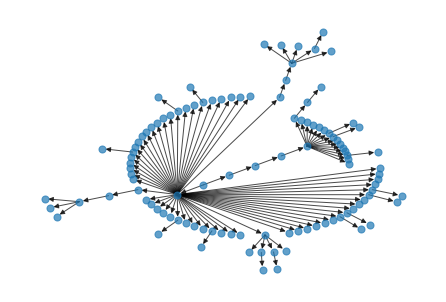

In [0]:
draw_tree(adjancecy_m_dict[new_nodes[0]])

Визуализация этого же дерева **на графе**

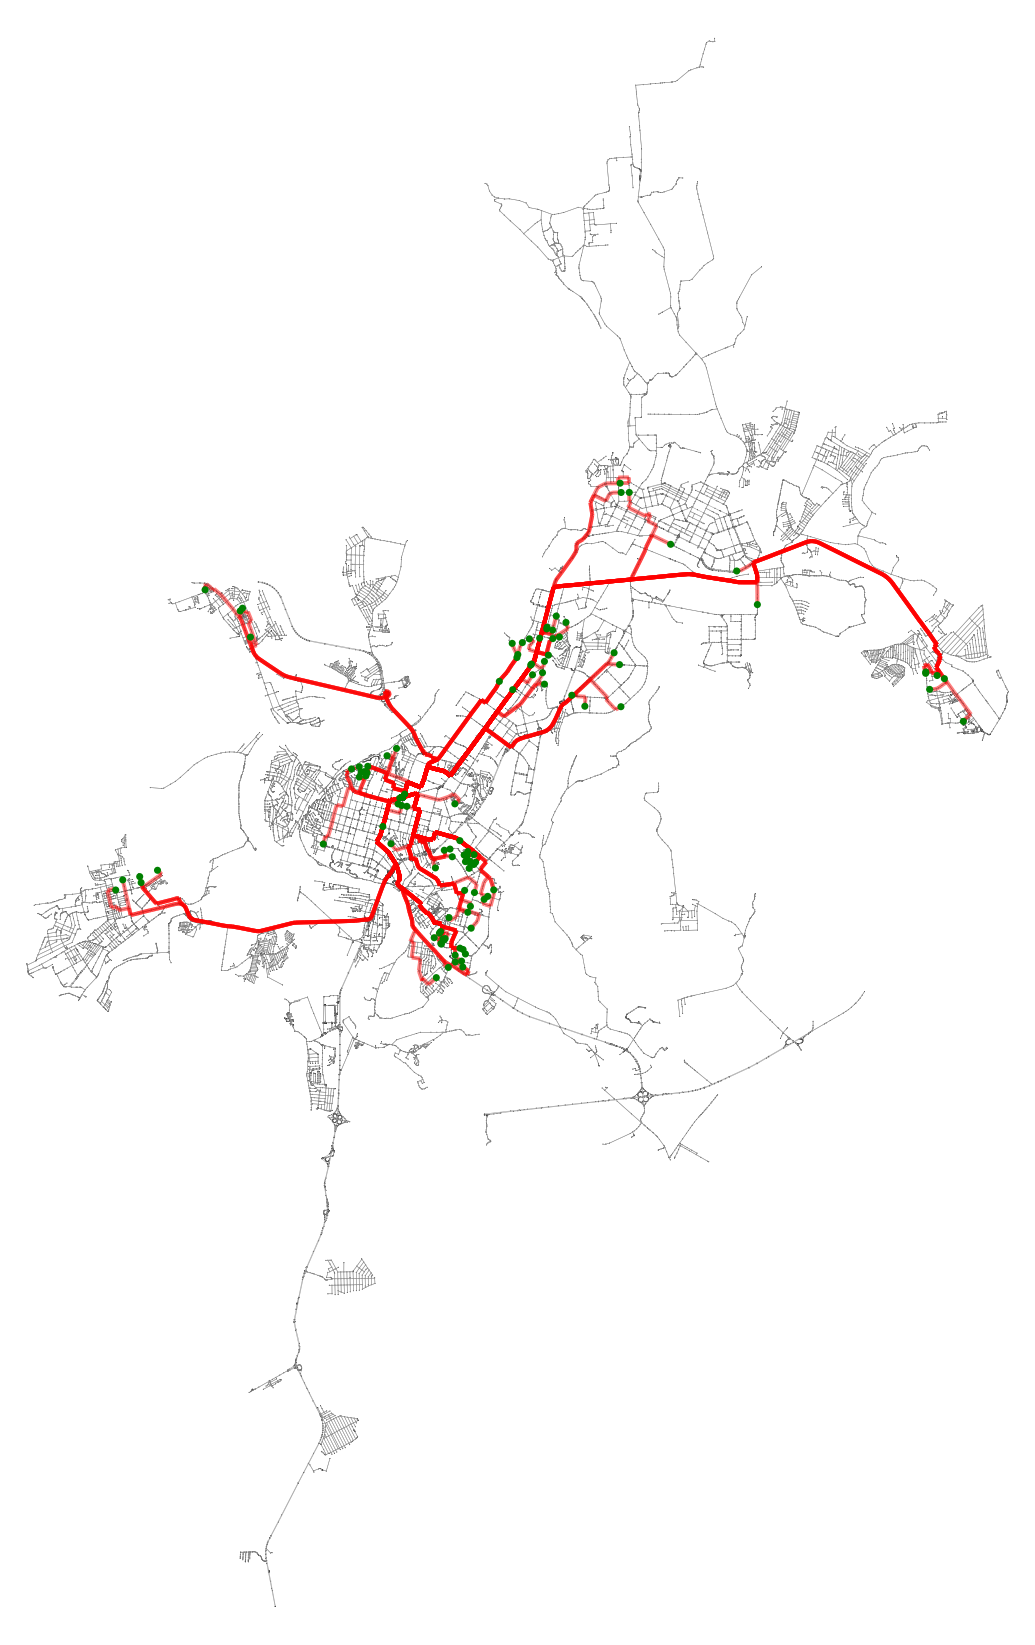

In [0]:
draw_tree_Ufa (new_nodes[0], paths[new_nodes[0]],  new_nodes)

# Первое задание.

#### Матрица кратчайших расстояний от больниц до жилых домов

In [0]:
#from numpy import genfromtxt
# считываем матрицу кратчайших расстояний из csv файла
# data = genfromtxt('/content/matrix_dijkstra.csv', delimiter=',') 

# можно загрузить эту матрицу если она есть в оперативке
data = short_path_matrix.copy()

In [0]:
#не нужно искать расстояние между жилыми домами

for i in range(M+N):
  if new_nodes[i] in apartments_values:
    for j in range(M+N):
      if new_nodes[j] in apartments_values:
        data[i][j] = 10**10

### Пункт 1.а 
Для каждого дома определить ближайший от узла объект (путь “туда”), ближайший к объекту узел (путь “обратно”), объект, расстояние до которого и обратно минимально (“туда и обратно”).

In [0]:
def task1a(sh_path_m, apartments_values, all_nodes):

  N = len(apartments_values)

  nearest_hosp_list = [[0 for i in range(3)] for j in range(N)]
  for i in range(N):
    node = apartments_values[i]
    index = np.where(all_nodes == node)
    # туда
    nearest_hosp_list[i][0] = all_nodes[sh_path_m[index][:].argmin()]
    # обратно
    nearest_hosp_list[i][1] = all_nodes[sh_path_m[:][index].argmin()]
    #туда и обратно
    nearest_hosp_list[i][2] = all_nodes[(np.array(sh_path_m[index][:]) + sh_path_m[:][index]).argmin()]
    
  return nearest_hosp_list
      


In [0]:
nearest_hosp_list = task1a(data, apartments_values, new_nodes)

#### Визуализируем результаты

In [0]:
# подготовим один из путей для визуализации
route = paths[apartments_values[0]][nearest_hosp_list[0][0]].copy()

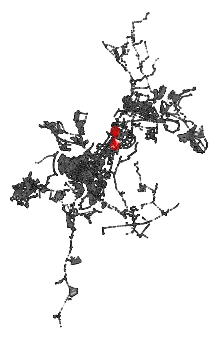

(<Figure size 468.322x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8cc1d42e10>)

In [0]:
# пример визуализации кратчайших путей (точки взяты из предыдущего пункта)

ox.plot_graph_route(G, route, dpi=500, node_color='#000000', node_size=2, edge_color='#999999', edge_linewidth=0.2, orig_dest_node_color='r')

### Пункт 1.b
Для каждого дома определить объекты, расположенные не далее, чем в X км для каждого из трех вариантов “туда”, “обратно”, “туда и обратно”.

In [0]:
# возвращаемый список содержит списки с 3-мя списками индексов подходящих объектов: "туда", "обратно" и "туда и обратно" 
# содержат своё количество индексов - это списки второго уровня,индекс списка первого уровня соответствует индексу дома во входной матрице расстояний. 
def find_in_radius(short_path_matrix, radius, apartments_values, new_nodes):

    permissible_hosps = [[[] for i in range(3)] for j in range(len(apartments_values))]

    for node in apartments_values:
        index = np.where(new_nodes == node)[0][0]
        for j in range(len(new_nodes)):
            if short_path_matrix[index][j] <= radius:
                permissible_hosps[index][0].append(new_nodes[j])
            if short_path_matrix[j][index] <= radius:
                permissible_hosps[index][1].append(new_nodes[j])
            if short_path_matrix[index][j] + short_path_matrix[j][index] <= radius:
                permissible_hosps[index][2].append(new_nodes[j])

    return permissible_hosps

In [0]:
# запуск программы, radius произвольный
radius = 100
hosps_in_radius = find_in_radius(data, radius, apartments_values, new_nodes)

#### Визуализируем результаты

In [0]:
i1 = np.where(new_nodes == apartments_values[0])[0][0]
i2 = np.where(new_nodes == hosps_in_radius[0][1][0])[0][0]
data[i1][i2] # < radius

94.0

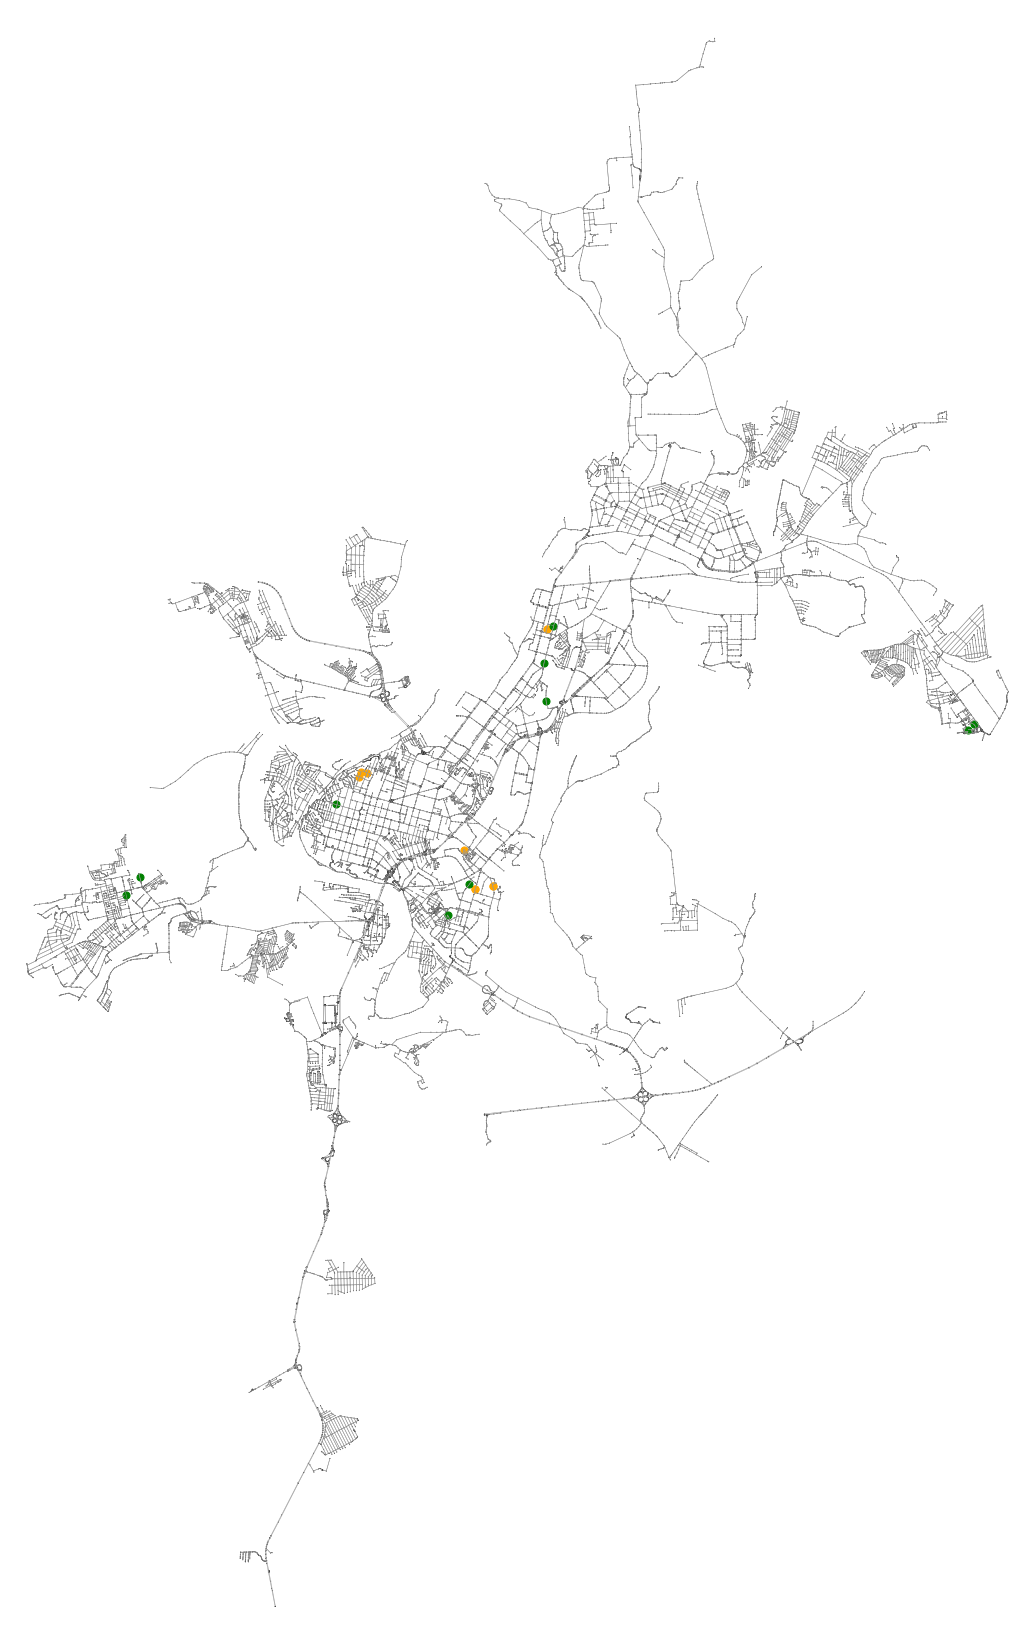

In [0]:
# можно на картиночке посмотреть несколько домов (и туда и обратно)
# зеленые - дома, оранжевые - больницы

k = 10

fig, ax = ox.plot_graph_routes(G, [], dpi=500, fig_height = 30, fig_width = 30,
                       node_color='#000000', node_size = 1, orig_dest_node_size=50, 
                       edge_color='#999999', edge_linewidth=0.5, show = False, close = False) 

for i in range(k):
  for hosp in hosps_in_radius[i][2]:
      ax.scatter(G.nodes[hosp]['x'], G.nodes[hosp]['y'], c = 'orange', s = 50)


for i in range(k):
    ap = apartments_values[i]
    ax.scatter(G.nodes[ap]['x'], G.nodes[ap]['y'], c = 'green', s = 50)

plt.show()

### Пункт 2
Определить, какой из объектов расположен так, что расстояние между ним и самым дальним домом минимально (“туда”, “обратно”, “туда и обратно”).

In [0]:
# возвращаемый список содержит три больницы - [ "туда", "обратно", "туда и обратно" ], где "туда" – из дома в больницу
def get_optimal_hospitals(short_path_matrix, hospital_values, apartments_values, new_nodes):

    optimal_hosps = []
    farthest_aps = []
    
    # подготовим необходимые матрицы
    there = short_path_matrix.copy()
    back = short_path_matrix.copy()
    iter1 = 0
    iter2 = 0

    for i in range (len(new_nodes )):
      if new_nodes[i] not in hospital_values:
        #удаляем cтроку
        there = np.delete(there, iter1, 0)
        #удаляем столбец
        back = np.delete(back, iter1, 1)
        iter1 -= 1

      else:
        #удаляем cтолбец
        there = np.delete(there, iter2, 1)
        #удаляем строку
        back = np.delete(back, iter2, 0)

        iter2 -= 1

      iter1 += 1
      iter2 += 1

    there = np.array(there)
    back = np.array(back)
    
    # туда 
    # возьмем минимум от максимума по столбцам
    index = (np.amax(there, 1)).argmin()
    optimal_hosps.append(hospital_values[index])
    farthest_aps.append(there[index, :].argmax())
    

    # обратно
    # возьмем минимум от максимума по строкам
    index = (np.amax(back, 0)).argmin()
    optimal_hosps.append(hospital_values[index])
    farthest_aps.append(back[:,index].argmax())

    # туда и обратно
    index = (np.amax(there, 1) + np.amax(back, 0)).argmin()
    optimal_hosps.append(hospital_values[index])
    farthest_aps.append((there[index, :] + back[:,index]).argmax())

    return optimal_hosps, farthest_aps

In [0]:
# запуск программы
opt, farthest_aps = get_optimal_hospitals(data, hospital_values, apartments_values, new_nodes)

#### Визуализируем результаты

In [0]:
print(opt)
print(farthest_aps)

[494786856, 1338629556, 494786856]
[84, 84, 84]


In [0]:
route = paths[opt[2]][apartments_values[farthest_aps[2]]]

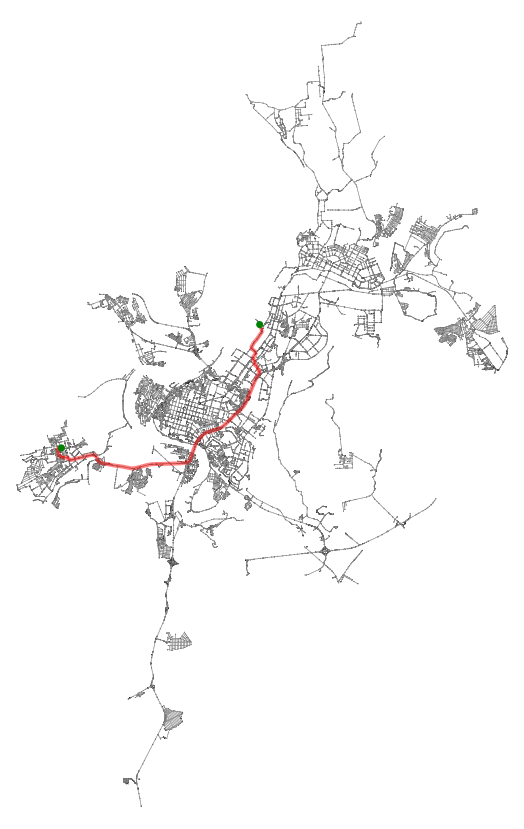

(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8ca2450da0>)

In [0]:
# путь от самой оптимальной больницы до самого дальнего для него дома

ox.plot_graph_route(G, route, dpi=500, fig_height = 15, fig_width = 15, 
                       node_color='#000000', node_size = 1, orig_dest_node_size=50, 
                       edge_color='#999999', edge_linewidth=0.5, orig_dest_node_alpha=1, orig_dest_node_color='g')

### Пункт 3

Определить, для какого объекта инфраструктуры сумма кратчайших расстояний от него до всех домов минимальна.

In [0]:
def from_hosp_to_ap_min_sum (short_path_matrix, hospital_values, new_nodes):
    
    short_path_hosp_to_ap = short_path_matrix.copy()
    iter1 = 0
    iter2 = 0

    for i in range (len(new_nodes )):
      if new_nodes[i] not in hospital_values:
        #удаляем cтроку
        short_path_hosp_to_ap = np.delete(short_path_hosp_to_ap, iter1, 0)
        iter1 -= 1

      else:
        #удаляем cтолбец
        short_path_hosp_to_ap = np.delete(short_path_hosp_to_ap, iter2, 1)
        iter2 -= 1

      iter1 += 1
      iter2 += 1

    index = (np.sum(short_path_hosp_to_ap, 1)).argmin()

    print(np.sum(short_path_hosp_to_ap[index]))
    return hospital_values[index]

In [0]:
# запуск программы
min_hosp_id = from_hosp_to_ap_min_sum(data, hospital_values, new_nodes)

10749.0


#### Визуализируем результаты

In [0]:
min_hosp_id

1388755403

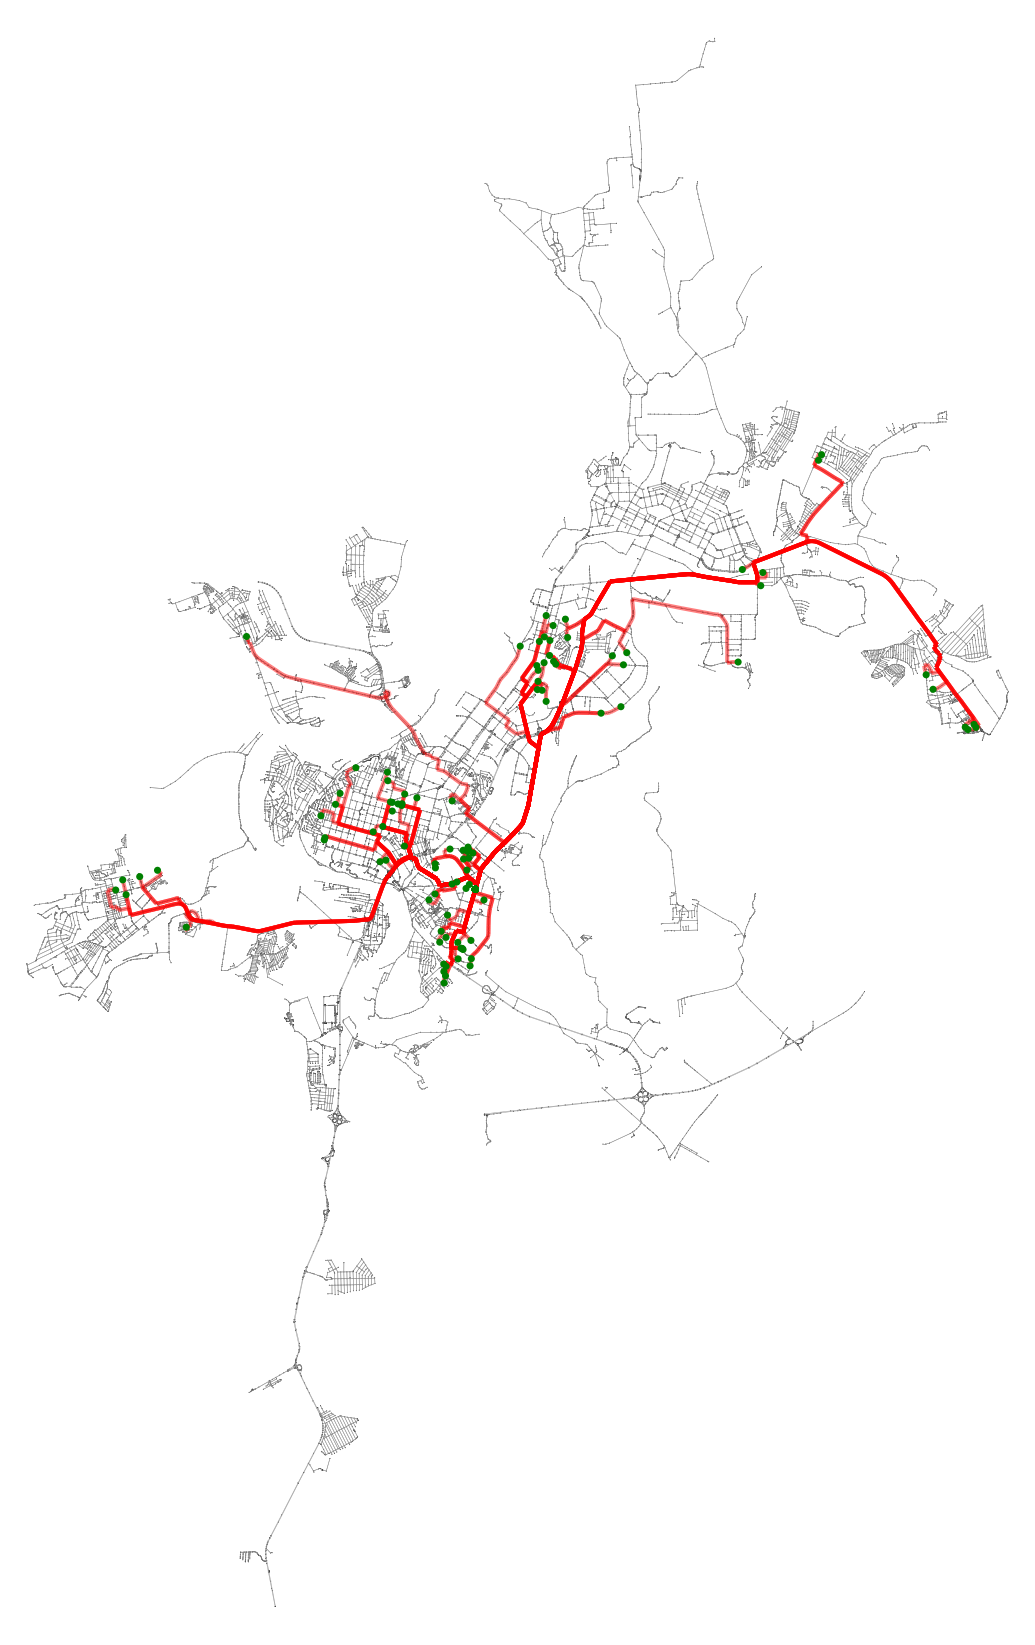

In [0]:
draw_tree_to_nodes(min_hosp_id, paths, apartments_values)

### Пункт 4
Определить, для какого объекта инфраструктуры построенное дерево кратчайших путей имеет минимальный вес.

In [0]:
# кладем дерево в стэк по вершинам, добавляя метку лист ли это

def tree_to_stack(stack, node, tree_adj):

      stack.append(node)
      node, _, islist = node 
      if not islist:
        for child in tree_adj[node]:
            child_node, e = child
            if len(tree_adj[child_node]) > 0:
              tree_to_stack(stack, (child_node, e, False), tree_adj)
            else:
              tree_to_stack(stack, (child_node, e, True), tree_adj)

In [0]:
# считаем только те ребра, по которым сможем попасть в вершины из списка

def weight_reduced_tree(stack, nodes):
  weight = 0
  parent_must_use = False
  last_list = False
  while len(stack)>0:
    node = stack.pop()
    node_id, e, islist = node
    if islist:
      if node_id in nodes:
          weight += e
          parent_must_use = True
          last_list = True
      elif not last_list:
        parent_must_use = False
    else:
      if node_id in nodes:
          weight += e
          parent_must_use = True
          last_list = True
      elif parent_must_use:
          last_list = False
          weight += e
  return weight


In [0]:
weights_of_tree = np.zeros(M)

for i in range(M):
  hosp = hospital_values[i]
  stack = []
  tree_to_stack(stack, (hosp, 0, False), small_tree_dict_adj[hosp])
  weights_of_tree[i] = weight_reduced_tree(stack, apartments_values)

hosp_min_weight_tree = hospital_values[weights_of_tree.argmin()]

#### Визуализируем результаты

In [0]:
hosp_min_weight_tree

1237275182

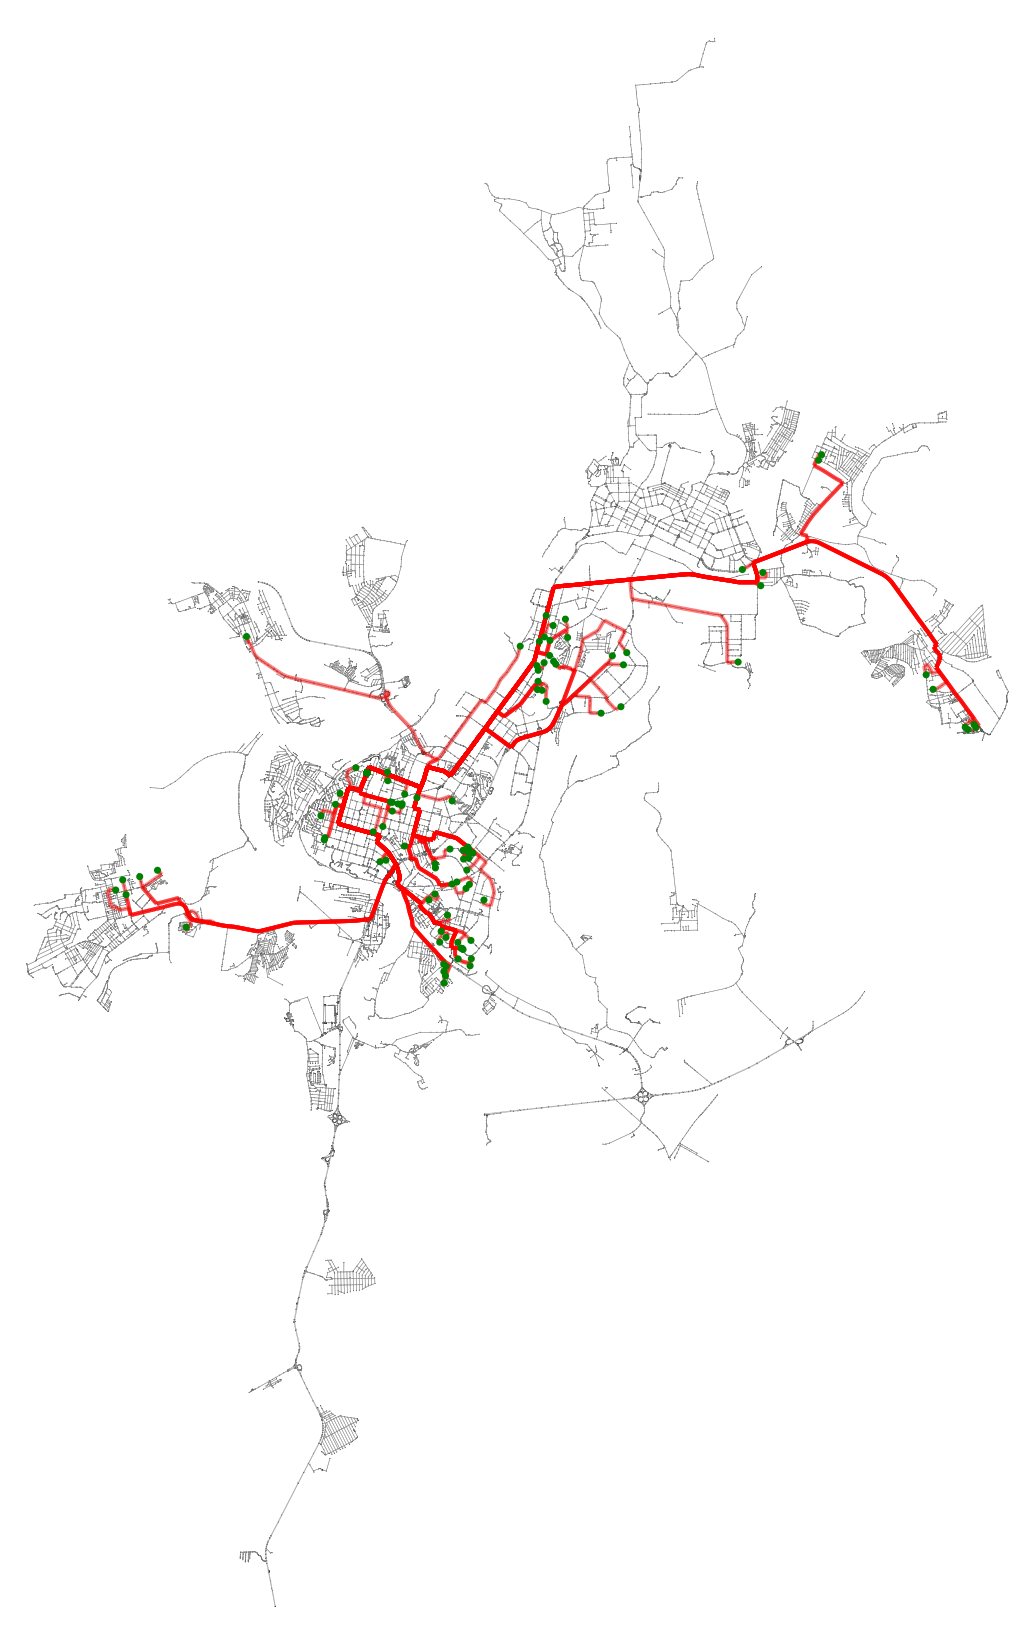

In [0]:
draw_tree_to_nodes(hosp_min_weight_tree, paths, apartments_values)

### Второе задание.
На карте случайным образом выбраны N узлов (домов) и один из объектов инфраструктуры.

### Пункт 1
Построить дерево кратчайших путей от объекта до выбранных узлов. Вычислить общую длину дерева, а также сумму кратчайших расстояний от объекта до всех заданных узлов.

In [0]:
  hosp_index = random.choice(hospital_values)
  number = np.where (hospital_values == hosp_index)[0]
  
  short_path_hosp_to_ap = short_path_matrix.copy()
  iter1 = 0
  iter2 = 0

  for i in range (len(new_nodes )):
    if new_nodes[i] not in hospital_values:
      #удаляем cтроку
      short_path_hosp_to_ap = np.delete(short_path_hosp_to_ap, iter1, 0)
      iter1 -= 1

    else:
      #удаляем cтолбец
      short_path_hosp_to_ap = np.delete(short_path_hosp_to_ap, iter2, 1)
      iter2 -= 1

    iter1 += 1
    iter2 += 1

In [0]:
# используем функциии из 1п4

stack = []

tree_to_stack(stack, (hosp_index, 0, False), small_tree_dict_adj[hosp_index])

# общая длина дерева
weights_of_hosp = weight_reduced_tree(stack, apartments_values)

#сумма кратчайших путей
for i in range (N):
  sum_shortest_paths = sum(short_path_hosp_to_ap[number][0])


sum_shortest_paths = int(sum_shortest_paths)


#### Результаты

In [0]:
hosp_index

826163319

In [0]:
weights_of_hosp

7661

In [0]:
sum_shortest_paths

12923

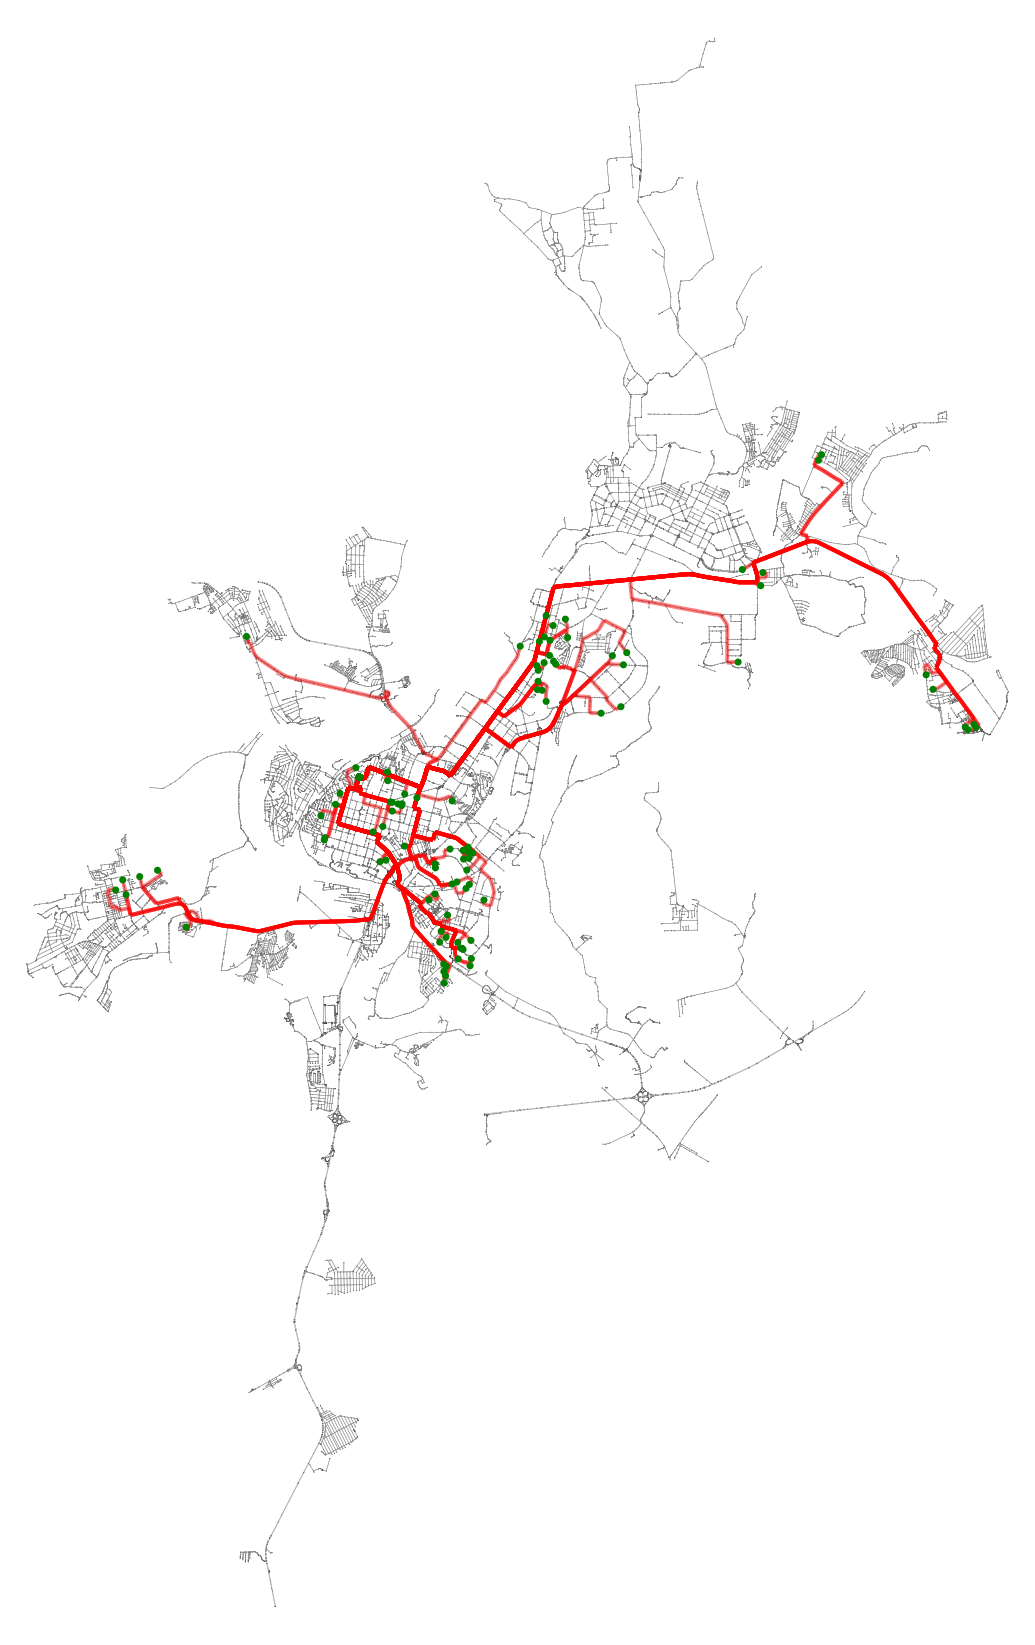

In [0]:
draw_tree_to_nodes(hosp_index, paths, apartments_values)

### Пункт 2
Разбить выбранные узлы на кластеры, используя метод полной связи (сomplete-linkage clustering). Построить дендрограмму разбиения узлов.

In [0]:
# создаем матрицу для работы далее
ap_path_matrix = np.zeros([len(apartments_values), len(apartments_values)])
strange_nodes = []

for i in range(len(apartments_values)):
  for j in range(len(apartments_values)):
    i1  = np.where(new_nodes == apartments_values[i])[0][0]
    i2  = np.where(new_nodes == apartments_values[j])[0][0]
    if short_path_matrix[i1][i2] == 10**10:
      ap_path_matrix[i][j] == 0
      if not i1 == i2:
        strange_nodes.append((i,j))
    else: 
      ap_path_matrix[i][j] = short_path_matrix[i1][i2]

for i,j in strange_nodes:
   ap_path_matrix[i][j] =  ap_path_matrix[j][i]

In [0]:
our_clusters = linkage(ap_path_matrix, method='complete')
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

####Визуализация

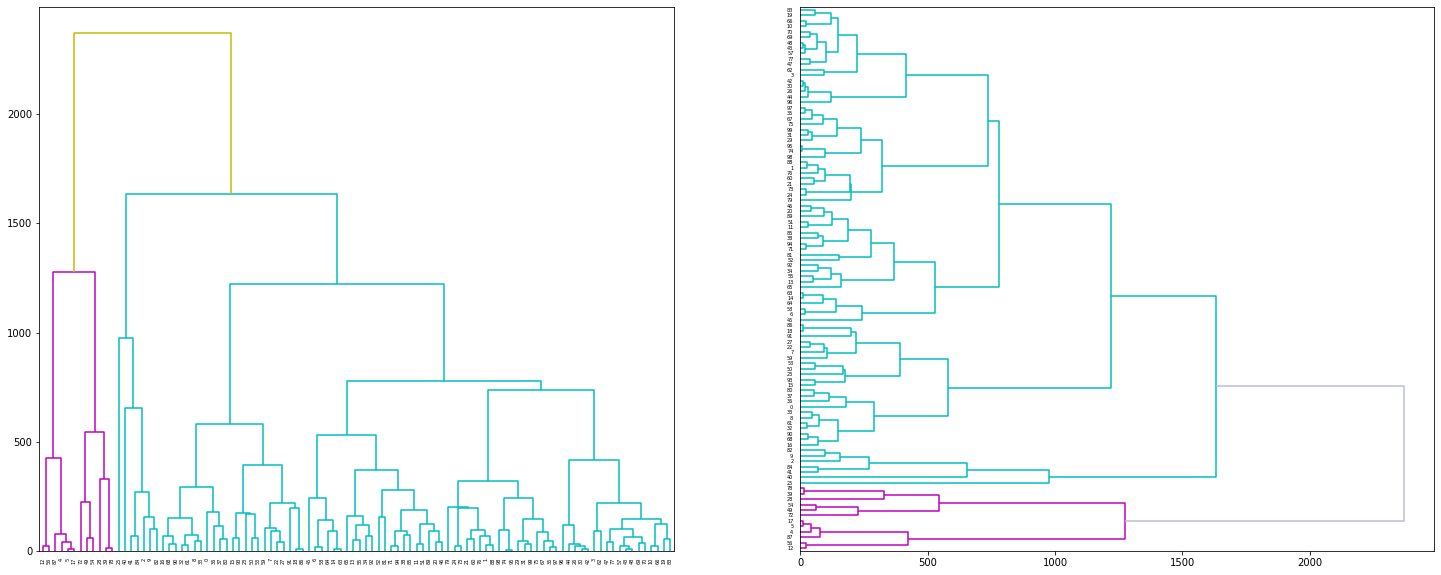

In [0]:
set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(25, 10))
dn1 = dendrogram(our_clusters, ax=axes[0], above_threshold_color='y', 
                 orientation='top')
dn2 = dendrogram(our_clusters, ax=axes[1], above_threshold_color='#bcbddc', 
                 orientation='right')
#plt.savefig('dendrogram', dpi=500, orientation='portrait', papertype=None, 
            #format=None, transparent=False, bbox_inches=None, pad_inches=0.1, 
            #frameon=None, metadata=None)

set_link_color_palette(None)  # reset to default after use
plt.show()

### Пункт 3
Пусть узлы разбиты на k кластеров.

a. Найти расположение центра масс (центроида) для каждого кластера;

b. Построить дерево кратчайших путей от объекта до центроидов.

c. Для каждого кластера построить дерево кратчайших путей от центроида до
всех вершин кластера.

d. Найти длину построенного дерева и сумму кратчайших расстояний от
объекта до всех заданных узлов.

In [0]:
def make_k_clusters(k, our_clusters, ap_path_matrix):

  clusters = fcluster(our_clusters, k, criterion='maxclust')

  clusters_us = {}
  clusters_us_id = {}
  for i in range(len(clusters)):
      j = clusters[i]
      if j in clusters_us:
          clusters_us[j].append(ap_path_matrix[i])
          clusters_us_id[j].append(i)
      else:
          clusters_us[j] = [ap_path_matrix[i]]
          clusters_us_id[j] = [i]
          
  for key, value in clusters_us.items():
      clusters_us[key] = np.array(value)

  return clusters, clusters_us, clusters_us_id

In [0]:
# разбиваем узлы на три кластера
k = 2

In [0]:
clusters, clusters_us, clusters_us_id = make_k_clusters(k, our_clusters, ap_path_matrix)

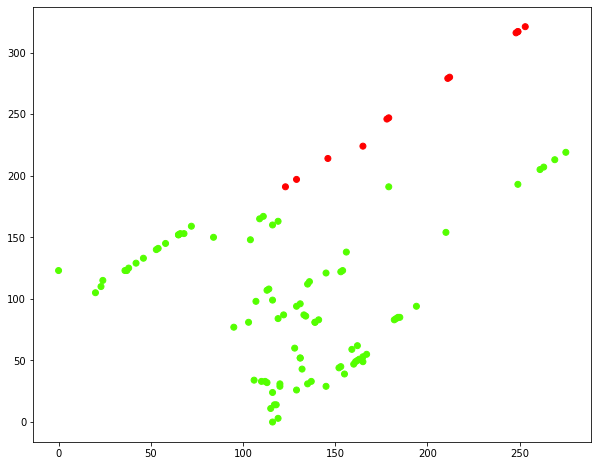

In [0]:
plt.figure(figsize=(10, 8))
plt.scatter(ap_path_matrix[:,0], ap_path_matrix[:,1], c=clusters, cmap='prism')
plt.show()

###Пункт 3.a
Найти расположение центра масс (центроида) для каждого кластера

Ищем центроиды

In [0]:
def centroids(X, Z, clusters,  k):

    plt.figure()
    plt.scatter(X[:,0], X[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent %colors
    
    clusters_us = {}
    clusters_us_id = {}
    for i in range(len(clusters)):
        j = clusters[i]
        if j in clusters_us:
            clusters_us[j].append(X[i])
            clusters_us_id[j].append(i)
        else:
            clusters_us[j] = [X[i]]
            clusters_us_id[j] = [i]
            
    for key, value in clusters_us.items():
        clusters_us[key] = np.array(value)
    
    centroids = {}
    centroids_node = {}
    for key, value in clusters_us.items():
        n = len(value)
        x = sum(value[:, 0]) / n
        y = sum(value[:, 1]) / n
        centroids[key] = [x, y]
        plt.scatter(x, y)

        e = 10000
        cent_node = 0
        for i in range(len(clusters_us_id[key])):
          dx = value[i, 0] - x
          dy = value[i, 1] - y
          e1 = ((dx+dy)**2)/2
          if (e1 < e):
            e = e1
            cent_node = i
        centroids_node[key] = clusters_us_id[key][cent_node]

    
    for key, value in clusters_us_id.items():
        n = len(value)
        x = 0
        y = 0
    
    print("Centroids")
    print(centroids)

    plt.savefig('centroids_in_clusters', dpi=500, orientation='portrait', papertype=None, 
            format=None, transparent=False, bbox_inches=None, pad_inches=0.1, 
            frameon=None, metadata=None)   
     
    plt.show()

    return  centroids_node

    '''
        for i in range (n):
          ap = apartments_values[value[i]]
          x += G.nodes[ap]['x']
          y += G.nodes[ap]['y']
        x = x/n
        y = y/n
        centroids_node[key] = ox.get_nearest_node(G, (y, x)) 
''' 

Centroids
{2: [126.5, 94.4659090909091], 1: [195.16666666666666, 262.4166666666667]}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


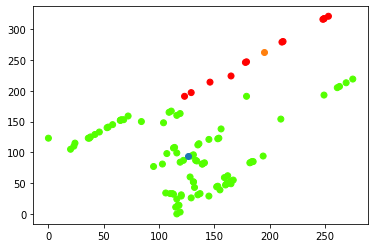

In [0]:
centroids_node = {}
centroids_node = centroids(ap_path_matrix, our_clusters, clusters, k)
for i in range(k):
    centroids_node[i+1] = apartments_values[centroids_node[i+1]]

Строим дерево кратчайших путей от объекта до центроидов.

###Пункт 3.b 
Построить дерево кратчайших путей от объекта до центроидов.

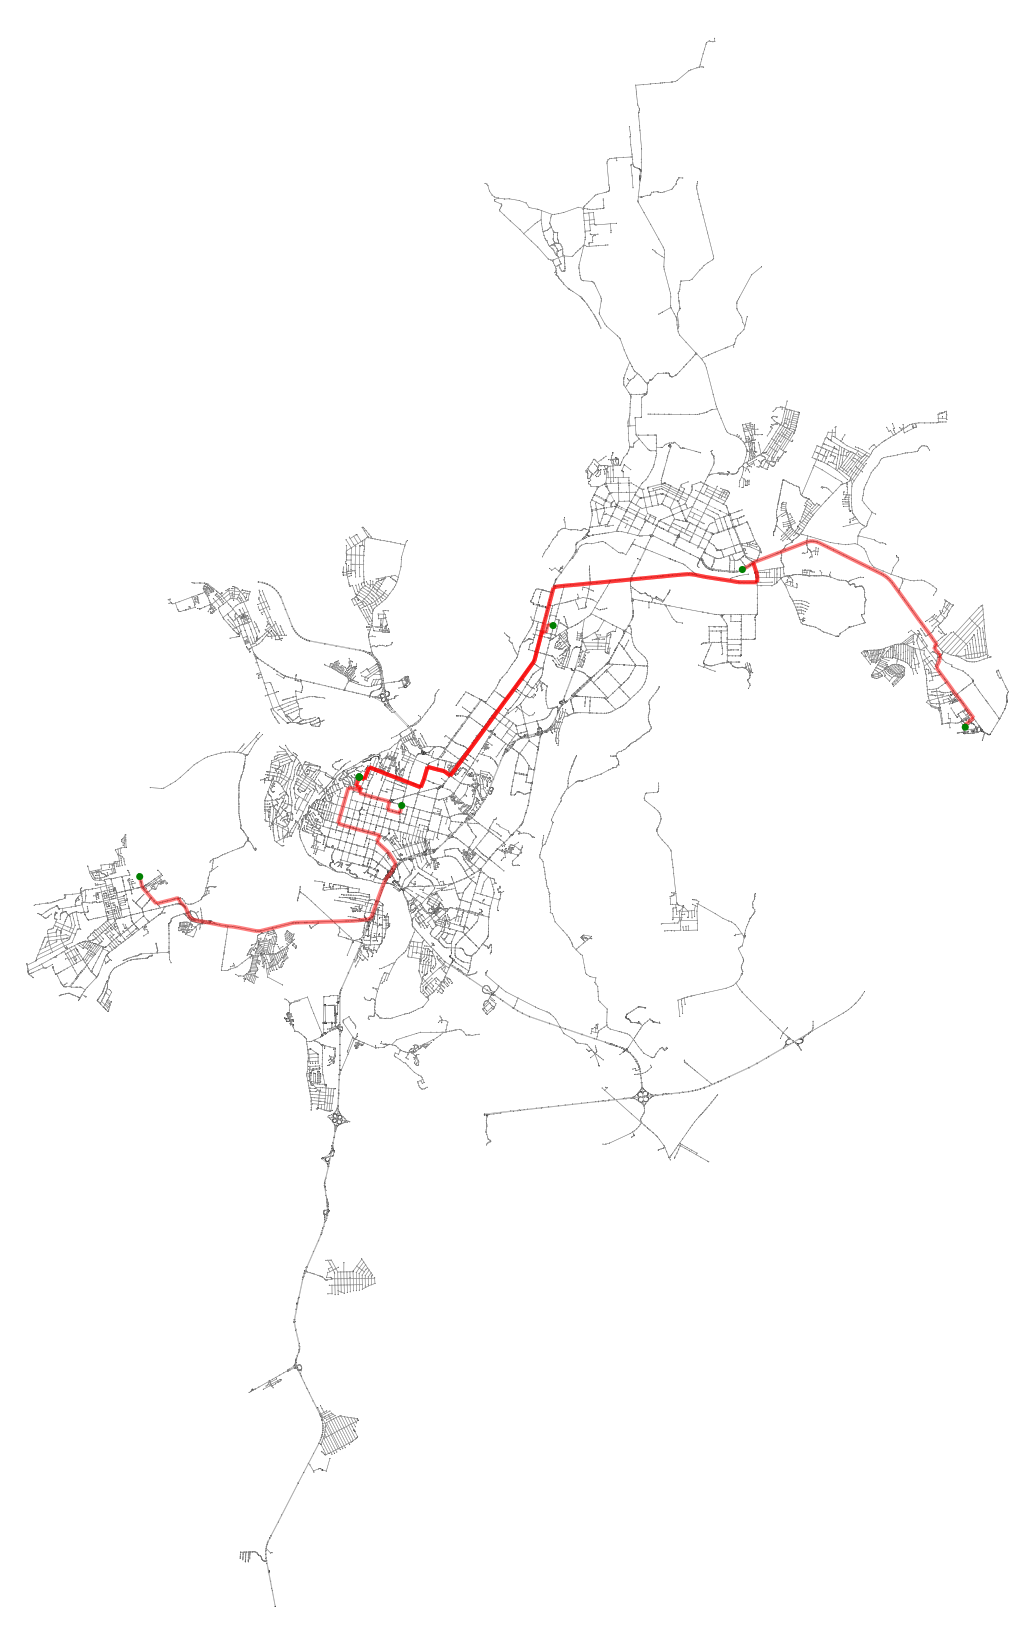

In [0]:
draw_tree_to_nodes (hosp_index, paths, centroids_node.values())

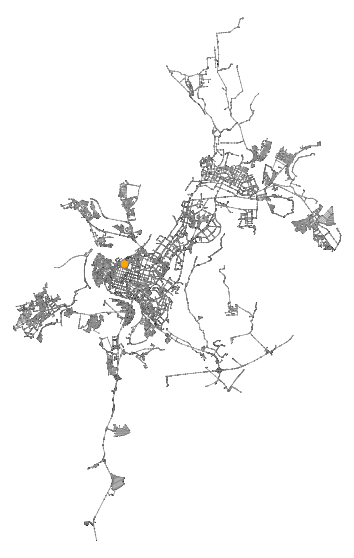

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8c977f9cf8>)

In [0]:
# посмотреть расположение больницы
ox.plot_graph_route(G, [hosp_index], dpi=500, fig_height = 10, fig_width = 10,
                       node_color='#000000', node_size = 1, orig_dest_node_size=50, 
                       edge_color='#999999', edge_linewidth=0.5, orig_dest_node_alpha=1, orig_dest_node_color='orange')

###Пункт 3.с
Для каждого кластера построить дерево кратчайших путей от центроида до всех вершин кластера.

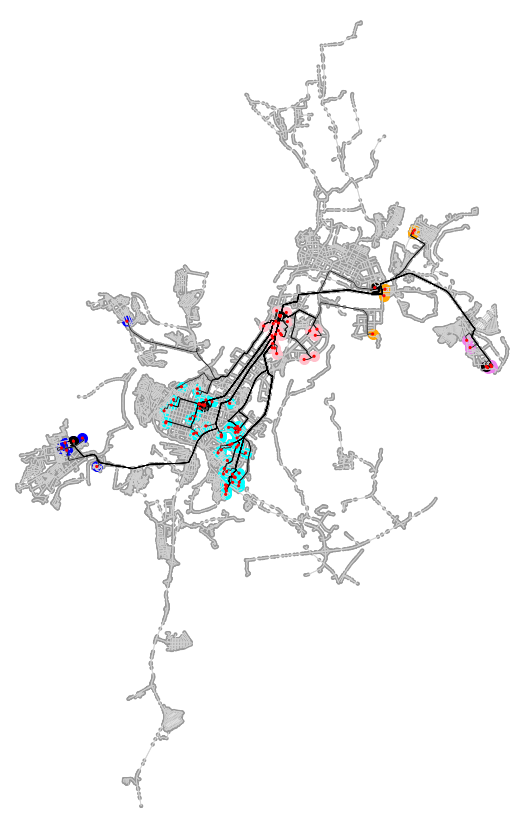

In [0]:
routes = make_routes_from_nodes(G, clusters_us_id.items(), centroids_node, apartments_values, nodes_list)

fig, ax = ox.plot_graph_routes(G, routes,  show = False, close = False, dpi=500, fig_height = 15, fig_width = 15, 
                                edge_color='lightgray', edge_alpha=1, edge_linewidth=0.8,
                                route_color='black', route_linewidth=0.8, route_alpha=1,
                                orig_dest_node_size=10, orig_dest_node_color='r', orig_dest_node_alpha=1)

for claster in range(1, k+1):
  if (claster%2 == 0 and claster%4!= 0):
    color = 'orange'
  elif claster%3 == 0:
    color = 'blue'
  elif claster%5==0:
    color = 'cyan'
  elif claster%4==0:
    color = 'pink'
  else:
    color = 'violet'

  for node in clusters_us_id[claster]:

    ap = apartments_values[node]
    ax.scatter(G.nodes[ap]['x'], G.nodes[ap]['y'], c = color, s = 100)

for key in centroids_node:
  ax.scatter(G.nodes[centroids_node[key]]['x'], G.nodes[centroids_node[key]]['y'], c = 'black', s = 100)


plt.show()

Найдем длину построенного дерева и сумму кратчайших расстояний от
объекта до всех заданных узлов.

### Пункт 3.d
Найти длину построенного дерева и сумму кратчайших расстояний от объекта до всех заданных узлов.

In [0]:
def task23d(hosp_index, small_tree_dict_adj, centroids_node, apartments_values,
            short_path_hosp_to_ap, number, short_path_matrix, k):

    # найдем ребра от hosp_index до центроид

    weight_centroids_tree = 0

    stack = []
    tree_to_stack(stack, (hosp_index, 0, False), small_tree_dict_adj[hosp_index])

    weight_centroids_tree +=  weight_reduced_tree(stack, list(centroids_node.values()))

    apartments = []
    for ap in apartments_values:
      if not ap in centroids_node.values():
        apartments.append(ap)

    # найдем веса деревьев от центроид до остальных жилых домов

    for node in centroids_node.values():

        stack = []
        tree_to_stack(stack, (node, 0, False), small_tree_dict_adj[node]) 
        weight_centroids_tree += weight_reduced_tree(stack, apartments)

    sum_shortest_paths_centroids = 0

    for i in range (k):
      ind = np.where(apartments_values == centroids_node[i+1])
      sum_shortest_paths_centroids += short_path_hosp_to_ap[number, ind] * len(apartments)
      for ap in apartments:
        i1 = np.where(new_nodes == centroids_node[i+1])
        i2 = np.where(new_nodes == ap)
        sum_shortest_paths_centroids += short_path_matrix[i1, i2]
      
    return weight_centroids_tree, int(sum_shortest_paths_centroids)


In [0]:
weight_centroids_tree, sum_shortest_paths_centroids = task23d(hosp_index, small_tree_dict_adj, centroids_node, apartments_values,
            short_path_hosp_to_ap, number, short_path_matrix,k)

In [0]:
weight_centroids_tree, sum_shortest_paths_centroids

(64076, 176487)

### Пункт 4
Сравнить найденные в п.1 и 3 величины для k=2, 3, 5

In [0]:
# вес дерева и сумма длин кратчайших путей соответственно

In [0]:
task23d(hosp_index, small_tree_dict_adj, centroids_node, apartments_values,
            short_path_hosp_to_ap, number, short_path_matrix, k)

(26413, 75602)

In [0]:
weights_of_hosp, sum_shortest_paths

(7661, 12923)